# Part 0: Startup

In [1]:
from datetime import timedelta
from decimal import Decimal
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as pe
format_k = lambda x, pos: f'{x/10**3:,.0f}K'
plt.style.use('https://raw.githubusercontent.com/learn-want/mpl_style/b5fdf16/uzh.mplstyle')
import warnings
# 忽略 pandas 警告
warnings.filterwarnings('ignore')
from matplotlib import font_manager

font_dirs = ['./Fonts']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)



# Part I Total Reward Sum by Daily

In [36]:
import pandas as pd
df_total=pd.read_parquet('/local/scratch/exported/Ethereum_token_txs_data_TY_23/rewards/eth2_reward_ether/daily_validator_index_reward/total_validator_reward.parquet')
data=df_total.groupby('date')[['Total reward','Proposer reward','Attestation reward','Sync committee reward']].sum().reset_index()
data.head()

,date,Total reward,Proposer reward,Attestation reward,Sync committee reward
0,2022-09-15,1.141728e+12,1.473330e+11,9.607365e+11,3.365839e+10
1,2022-09-16,1.590101e+12,2.051971e+11,1.336935e+12,4.796853e+10
2,2022-09-17,1.609977e+12,2.064542e+11,1.354427e+12,4.909521e+10
3,2022-09-18,1.620495e+12,2.071120e+11,1.363917e+12,4.946610e+10
4,2022-09-19,1.626214e+12,2.074213e+11,1.369821e+12,4.897241e+10


In [3]:
data=data.sort_values(by='date') # sort by date
#Convert Gwei to Ether
data=data.set_index('date')
data=data/(10**9)
data=data.reset_index()
df=data.copy()
df=df.iloc[1:] # cut the first day and last day
df.rename(columns={'final_total_reward':'Total reward','proposer_total_reward':'Proposer reward','attestation_total_reward':'Attestation reward','sync_total_reward':'Sync committee reward'
                   },inplace=True)# Get columns that end with '_reward'
df['date']=pd.to_datetime(df['date'])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: TheSans


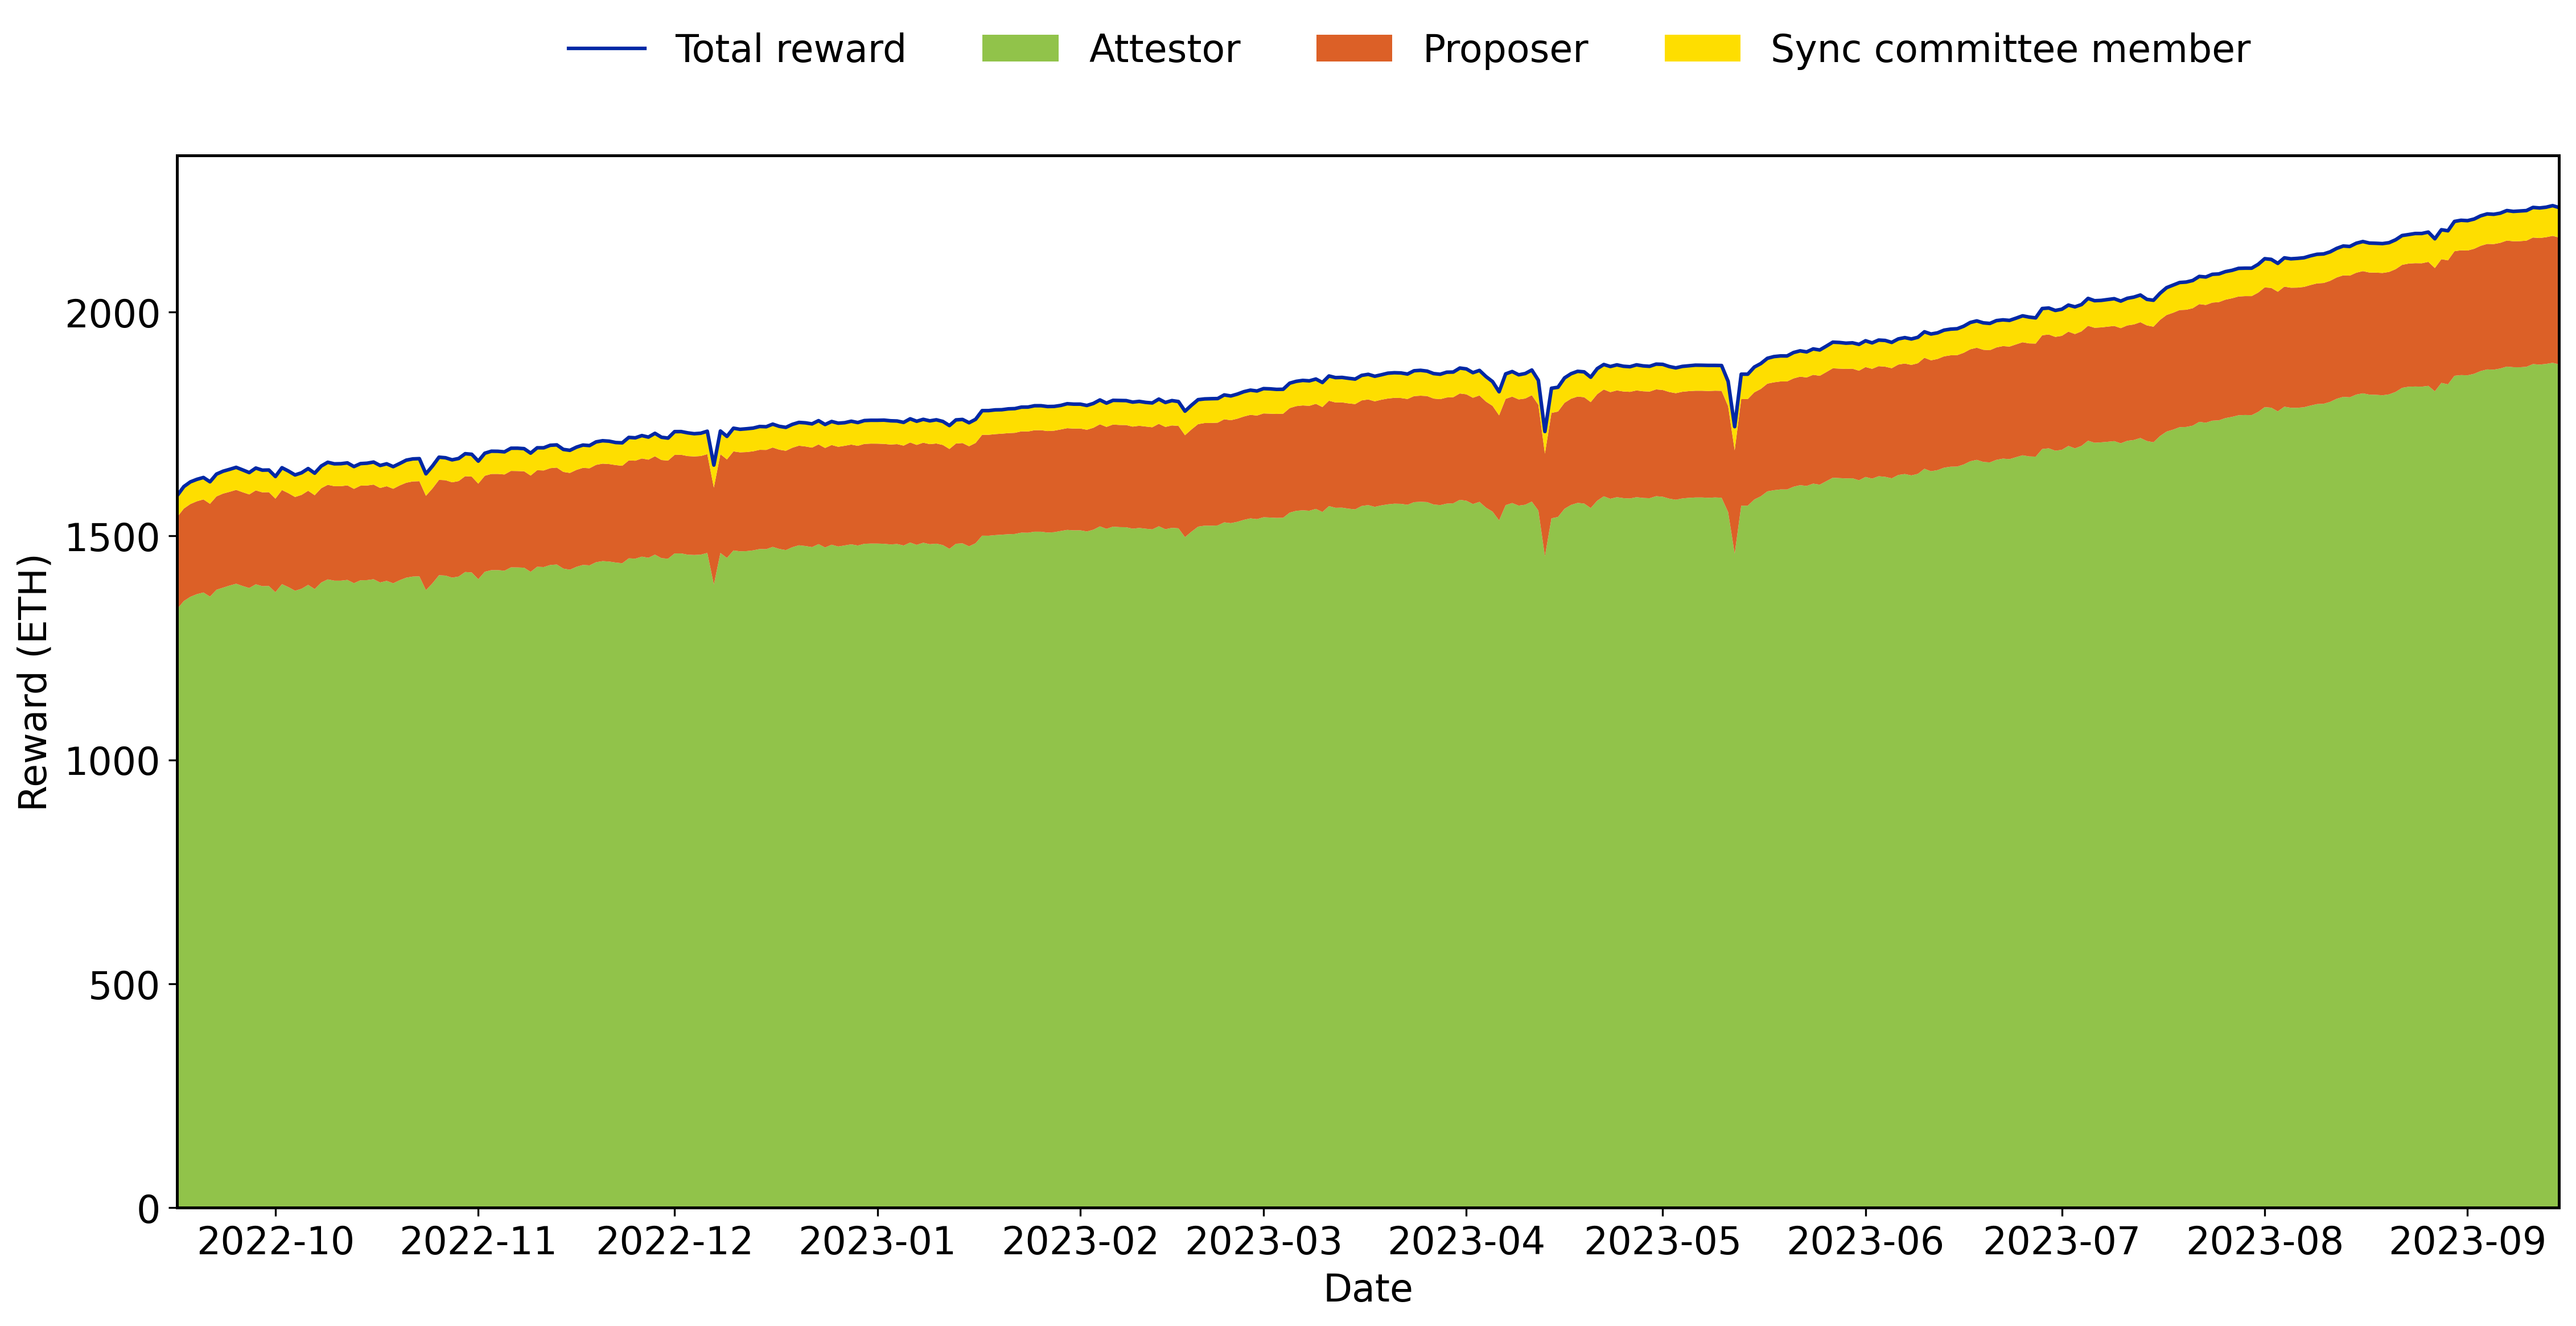

In [4]:
fig, ax = plt.subplots(figsize=(18, 8), dpi=300)
ax.plot(df['date'], df['Total reward'], label='Total reward',linewidth=1.5)
ax.stackplot(df['date'], df['Attestation reward'], df['Proposer reward'], df['Sync committee reward'], labels=['Attestor', 'Proposer', 'Sync committee member'],colors=['#91c34a', '#dc6027', '#fede00'])
ax.set_xlabel('Date',fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel('Reward (ETH)',fontsize=16)
ax.legend(fontsize=16)
# ax.set_title('Daily reward',fontsize=14)
ax.set_xlim(left=df['date'].iloc[0])
ax.set_xlim(right=df['date'].iloc[-1])
ax.legend(loc='upper left',fontsize=16,ncol=4,bbox_to_anchor=(0.15,1.15),frameon=False)
# ax.set_ylim(bottom=0)
plt.savefig('../figure/total_reward_daily.pdf',bbox_inches='tight',dpi=300,facecolor='white')

## daily reward value distribution

Intuitive impression: how many Ether per day for each type of reward. 

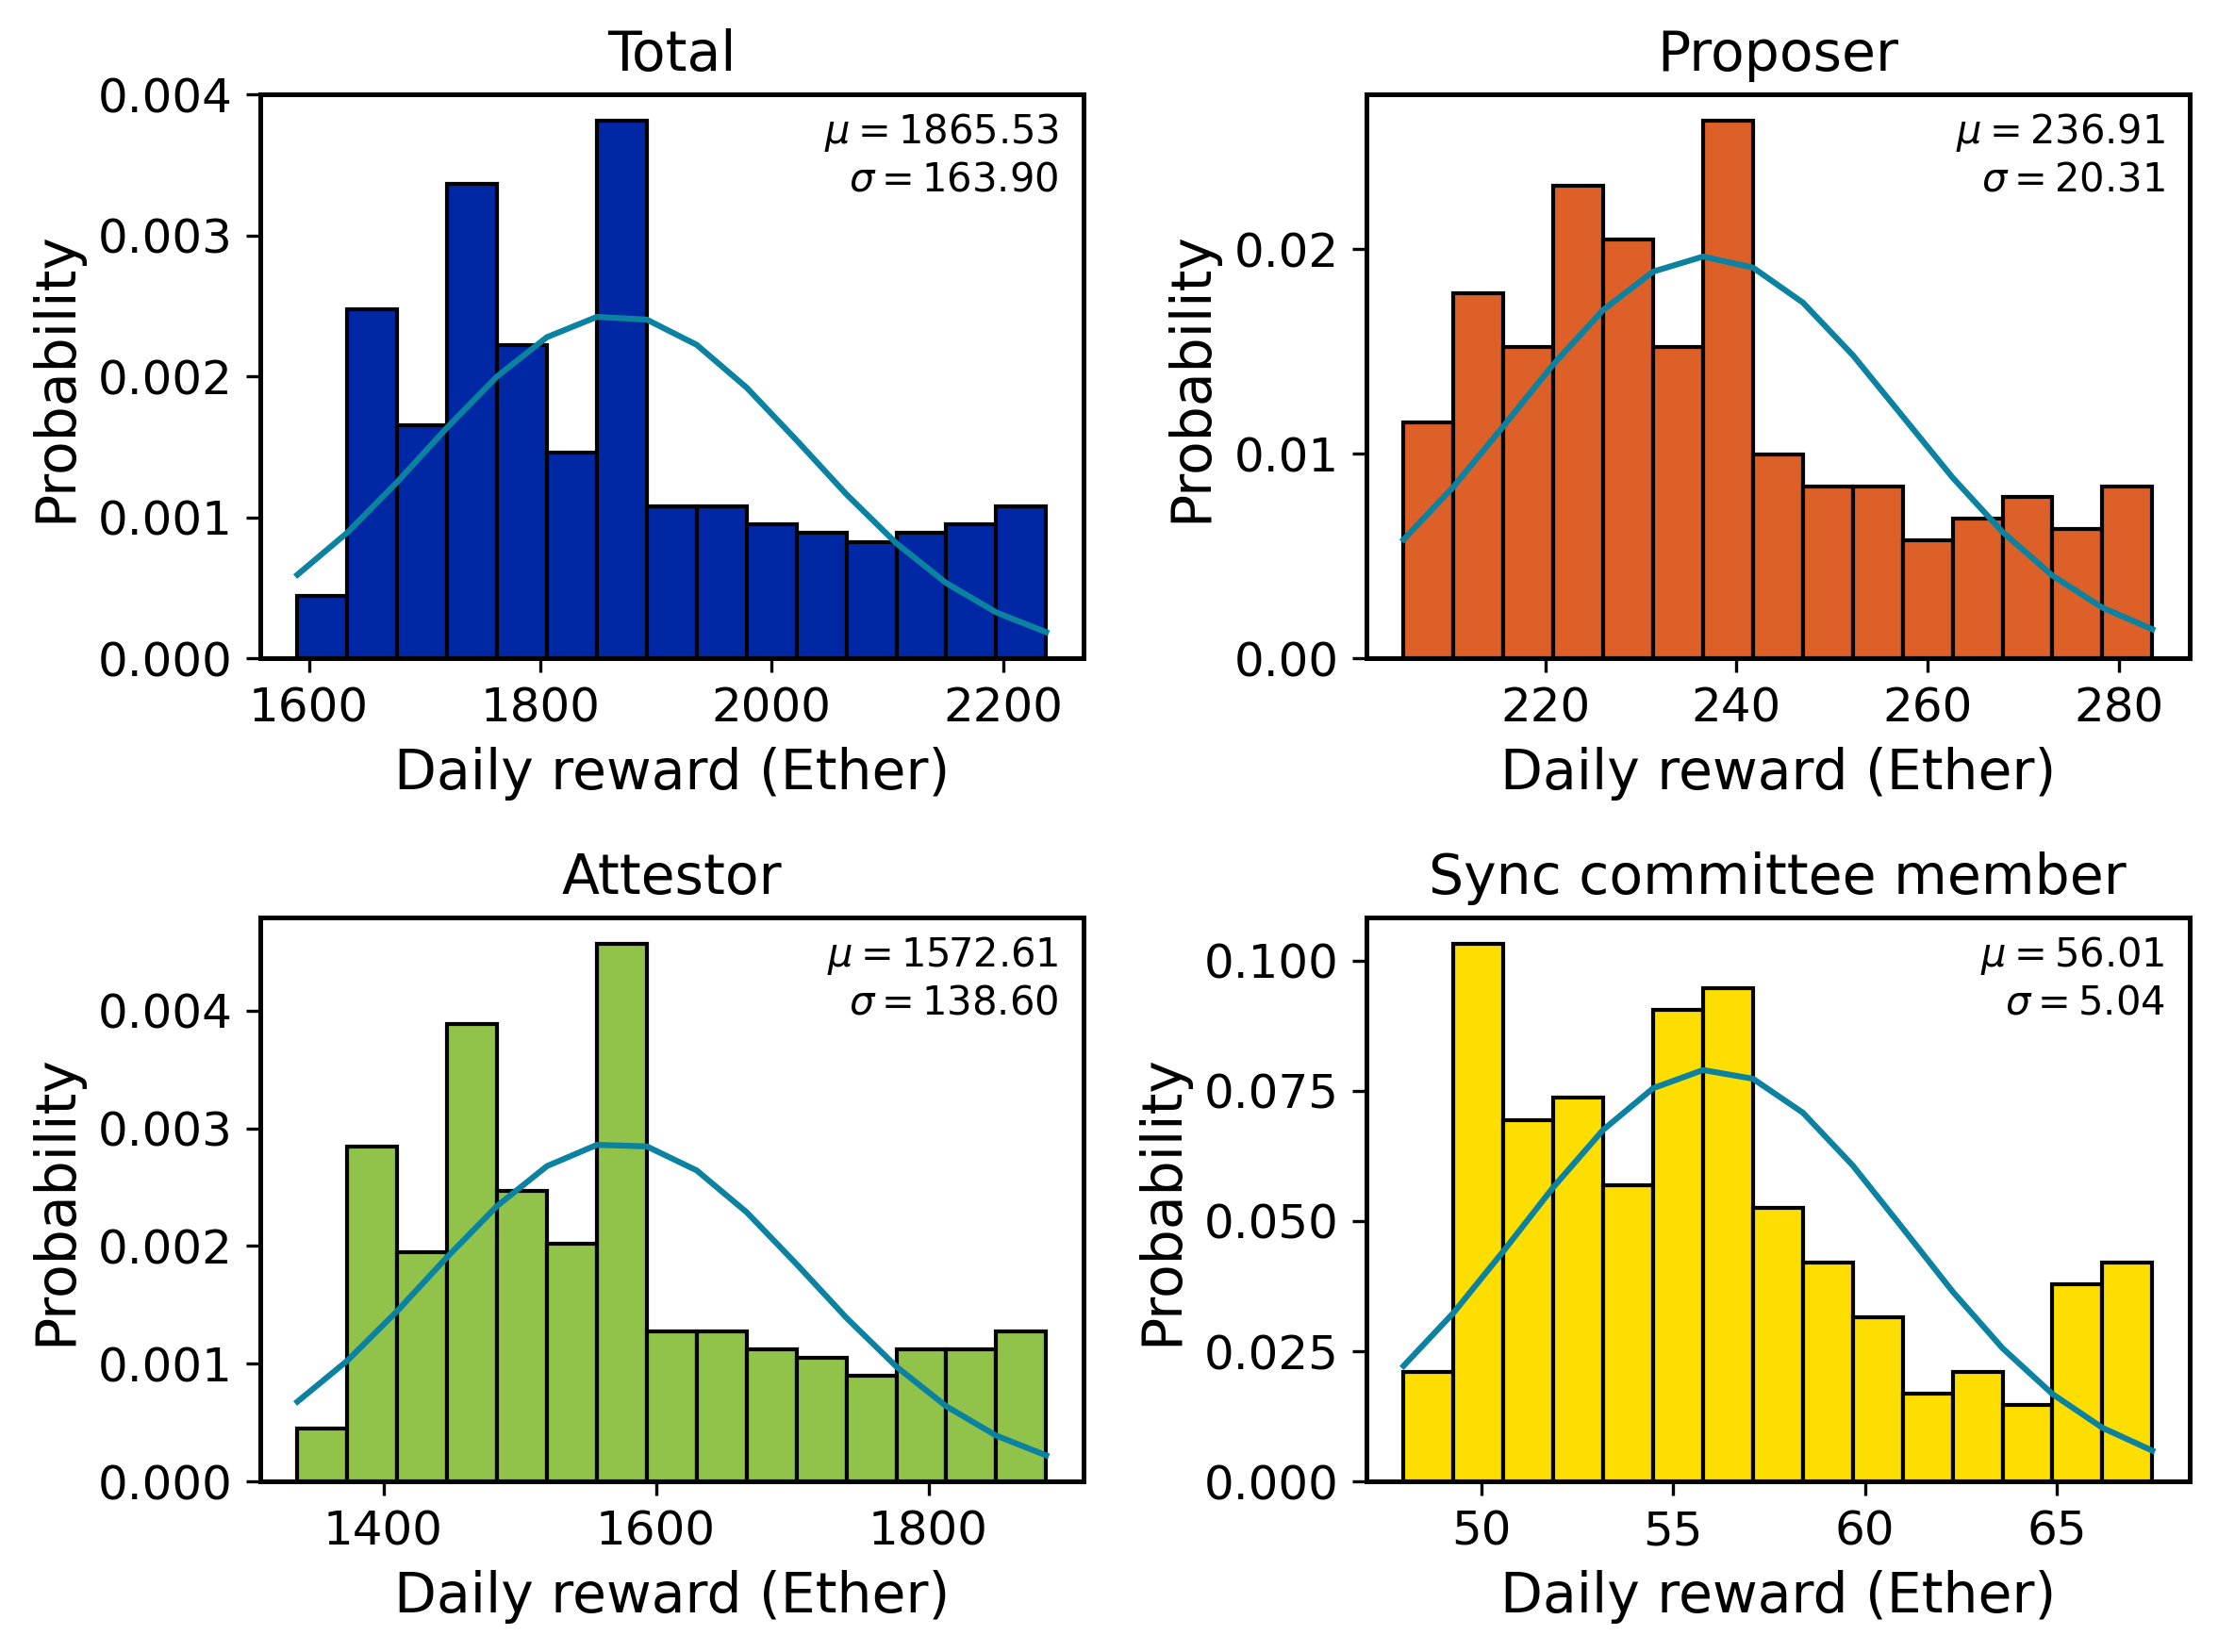

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

columns_to_plot = df.columns[1:5]
colors = ['#0028a5', '#dc6027', '#91c34a', '#fede00']

# Define subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Flatten the 2x2 array of axes for easier indexing
axes = axes.flatten()

# Add histograms to each subplot column
for i, column in enumerate(columns_to_plot):
    x = df[column].apply(float)
    mu = x.mean()
    sigma = x.values.std()
    num_bins = 15
    n, bins, patches = axes[i].hist(x, num_bins, density=1, edgecolor='black', color=colors[i])
    y = stats.norm.pdf(bins, mu, sigma)
    axes[i].plot(bins, y, color='#0b82a0', linewidth=1.5)
    axes[i].text(0.97, 0.97, f'$\mu={mu:.2f}$\n$\sigma={sigma:.2f}$', verticalalignment='top',
                 horizontalalignment='right', transform=axes[i].transAxes, fontsize=10)
    # axes[i].legend(loc='upper right', fontsize=14)
    if column == 'Sync committee reward':
        axes[i].set_title('Sync committee member', fontsize=14)
    elif column == 'Attestation reward':
        axes[i].set_title('Attestor', fontsize=14)
    else:
        axes[i].set_title(column.split(' ')[0], fontsize=14)
    axes[i].set_xlabel('Daily reward (Ether)', fontsize=14)
    axes[i].set_ylabel('Probability', fontsize=14)

plt.tight_layout()

plt.savefig('../figure/reward5_histogram_daily.pdf',bbox_inches='tight',dpi=300,facecolor='white')



## Daily reward among validators

showing how many Ether each validator get per day for each type of reward.

In [3]:
df=pd.read_parquet('/local/scratch/exported/Ethereum_token_txs_data_TY_23/rewards/eth2_reward_ether/daily_validator_index_reward/total_validator_reward.parquet')

In [4]:
df.head(2)

,date,validator_index,Total reward,Attestation reward,Proposer reward,Sync committee reward
0,2022-09-15,0.0,2332229.0,2332229.0,0.0,0.0
1,2022-09-15,285743.0,2315295.0,2315295.0,0.0,0.0


In [7]:
# sum up the reward of each validator
validators_reward=df.groupby('validator_index')[['Total reward','Proposer reward','Attestation reward','Sync committee reward']].sum()
validators_reward=validators_reward/10**9
validators_reward=validators_reward.reset_index()
validators_reward.columns

Index(['validator_index', 'Total reward', 'Proposer reward',
       'Attestation reward', 'Sync committee reward'],
      dtype='object')

Total reward
895203
Proposer reward
895203


Attestation reward
895203
Sync committee reward
895203


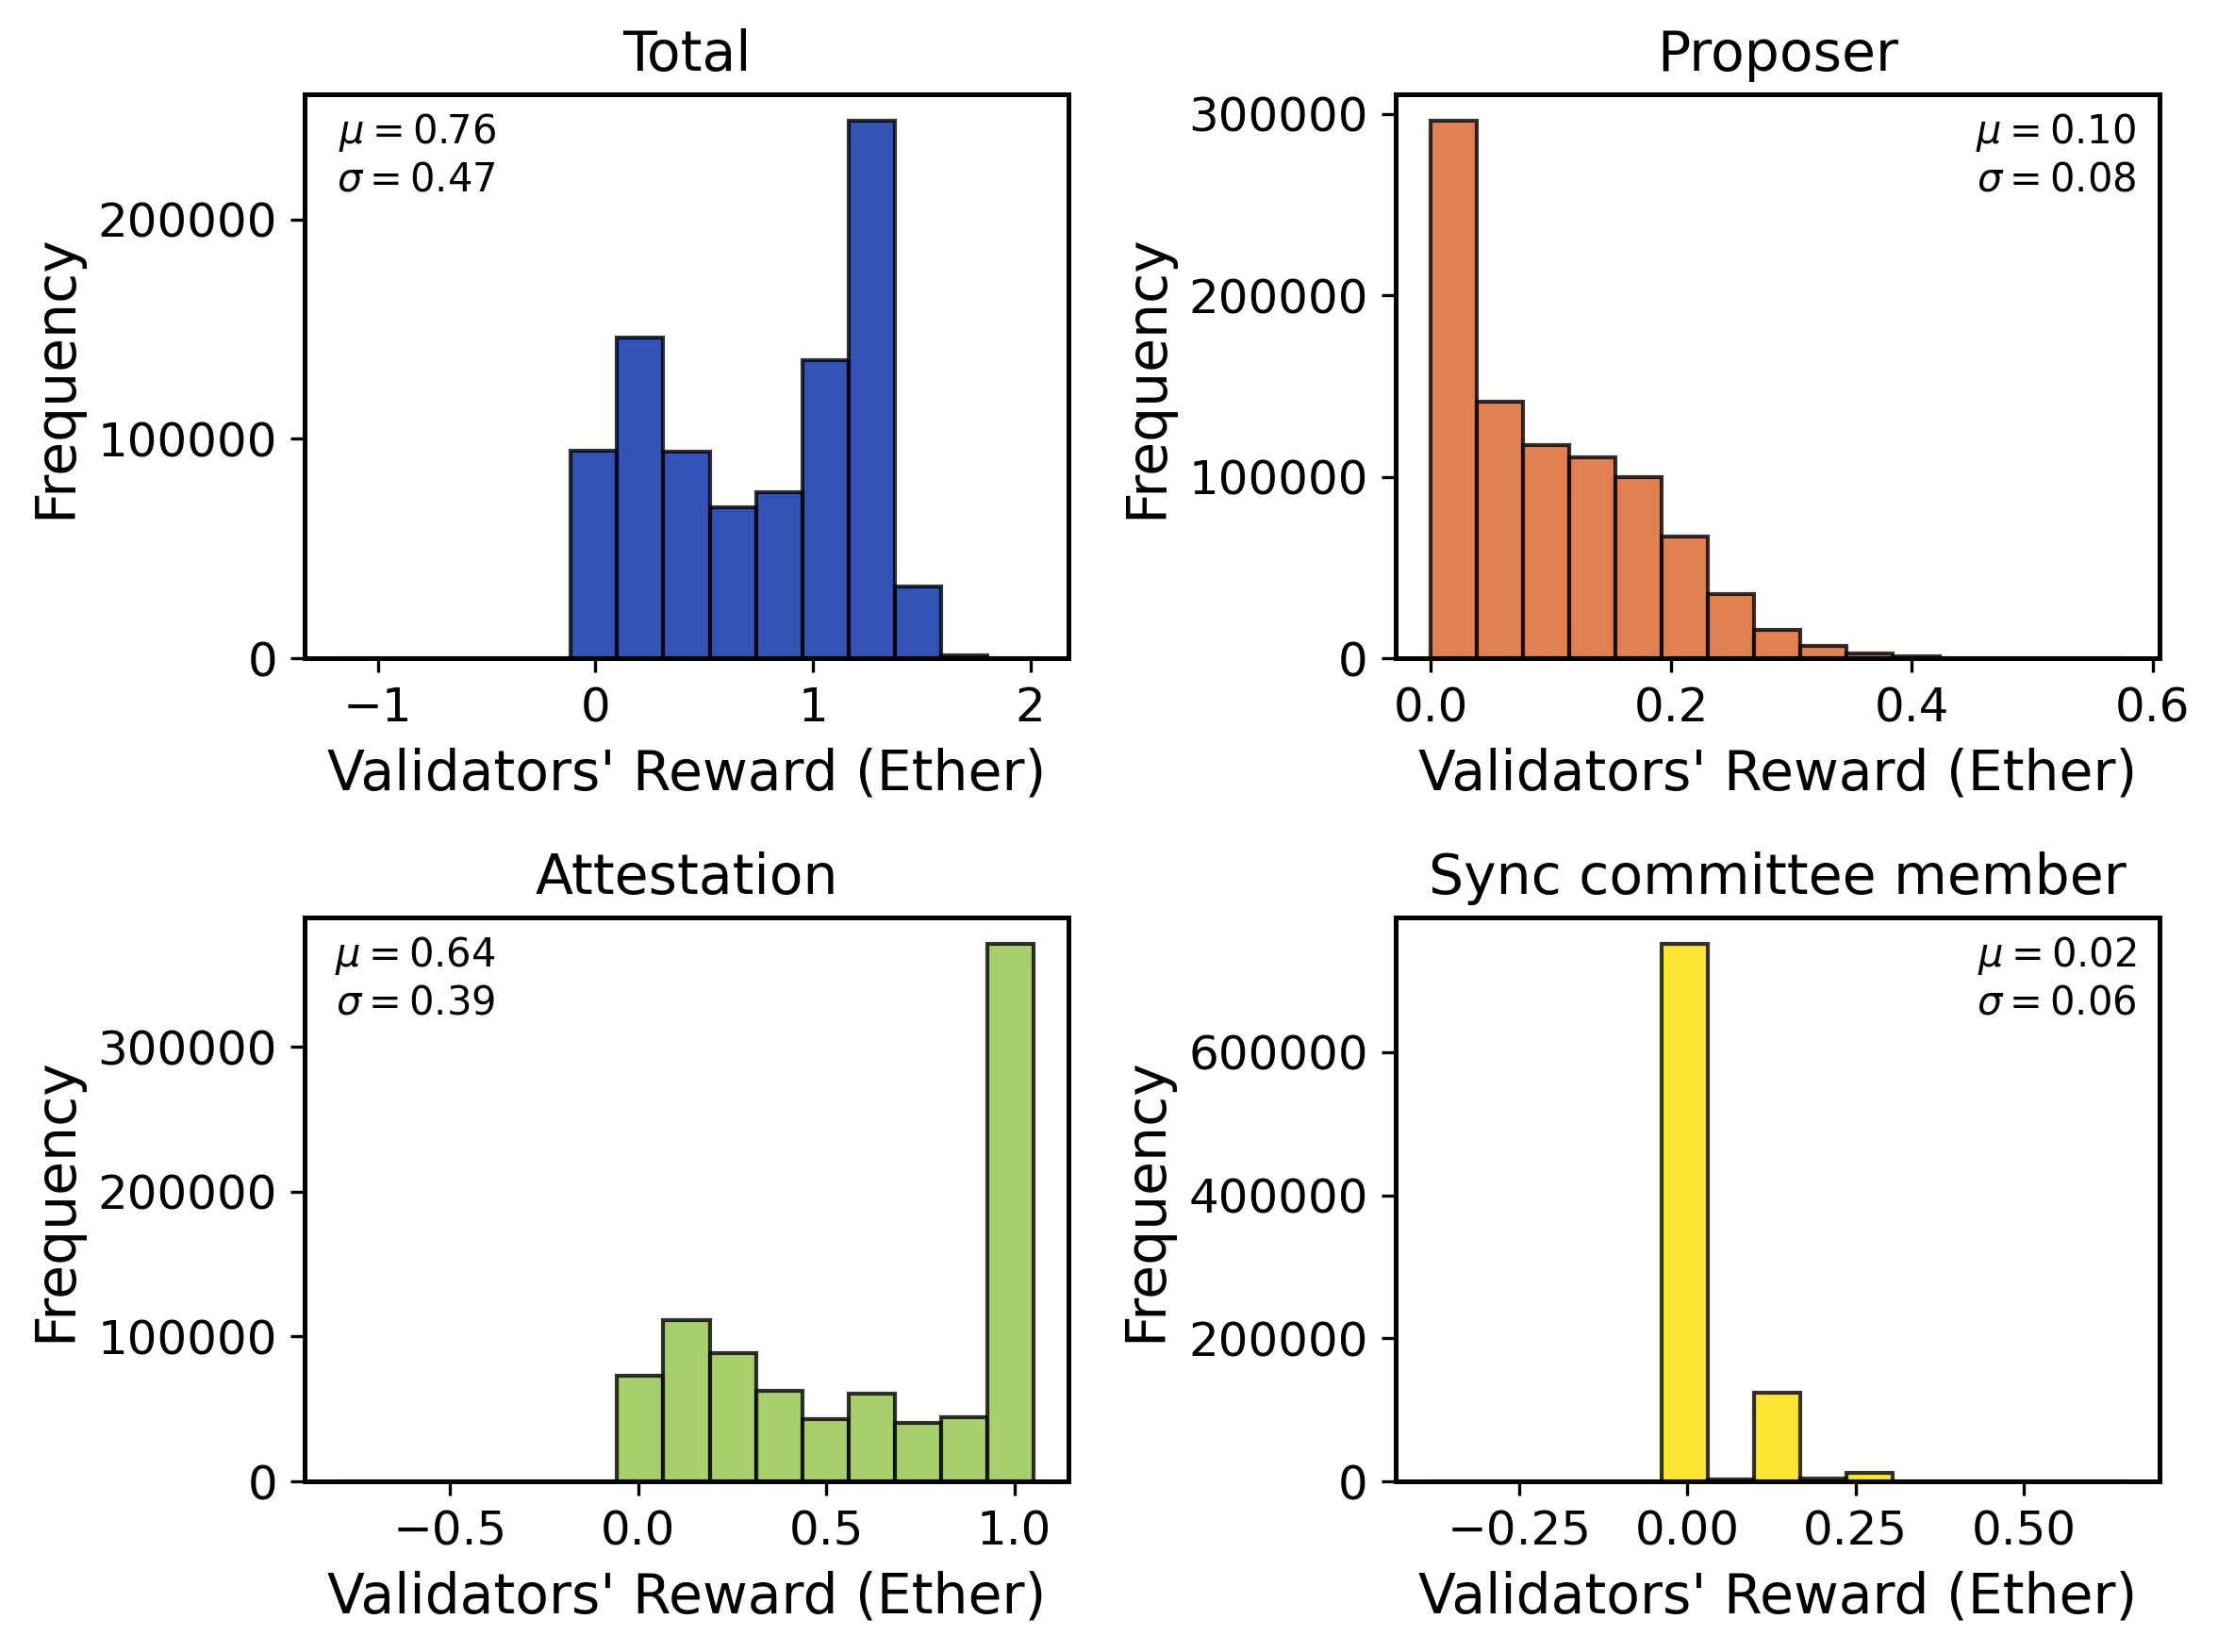

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
# Add histograms to each subplot column
labels = ['Total', 'Proposer', 'Attestation', 'Sync committee member']
colors = ['#0028a5', '#dc6027', '#91c34a', '#fede00']

for i, j in enumerate(validators_reward.columns[1:5], start=0):
    print(j)
    print(len(validators_reward))
    
    x = validators_reward[j].apply(float)
    mu = x.mean()
    sigma = x.std()
    num_bins = 15
    
    axes[i // 2][i % 2].hist(x, bins=num_bins, alpha=0.8, label=labels[i], edgecolor='black', color=colors[i])
    y = stats.norm.pdf(axes[i // 2][i % 2].patches[0].get_x(), mu, sigma)
    axes[i // 2][i % 2].plot(axes[i // 2][i % 2].patches[0].get_x(), y, color='#0b82a0', linewidth=1.5)
    if j=='Total reward' or j=='Attestation reward':
        axes[i // 2][i % 2].text(0.25, 0.97, f'$\mu={mu:.2f}$\n$\sigma={sigma:.2f}$', verticalalignment='top',
                             horizontalalignment='right', transform=axes[i // 2][i % 2].transAxes, fontsize=10)
    else:
        axes[i // 2][i % 2].text(0.97, 0.97, f'$\mu={mu:.2f}$\n$\sigma={sigma:.2f}$', verticalalignment='top',
                             horizontalalignment='right', transform=axes[i // 2][i % 2].transAxes, fontsize=10)
    
    axes[i // 2][i % 2].set_title(labels[i], fontsize=14)
    axes[i // 2][i % 2].set_xlabel("Validators' Reward (Ether)", fontsize=14)
    axes[i // 2][i % 2].set_ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.savefig('../figure/reward6_distribution_daily_validator.pdf',bbox_inches='tight',dpi=300,facecolor='white')

In [ ]:
df.shape

(27253258, 6)

In [ ]:
df.groupby('date')[['validator_index']].count().reset_index().to_csv('./data/daily_validator_number_new.csv',index=False)

## valdator number and average reward of validators

In [5]:
df=df[(df['date']>=pd.to_datetime('2022-09-15'))&(df['date']<=pd.to_datetime('2023-09-15'))]
validator_counts = df.groupby('date')['validator_index'].nunique().reset_index()
validator_means = df.groupby('date')['Total reward'].mean().reset_index()


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: TheSans


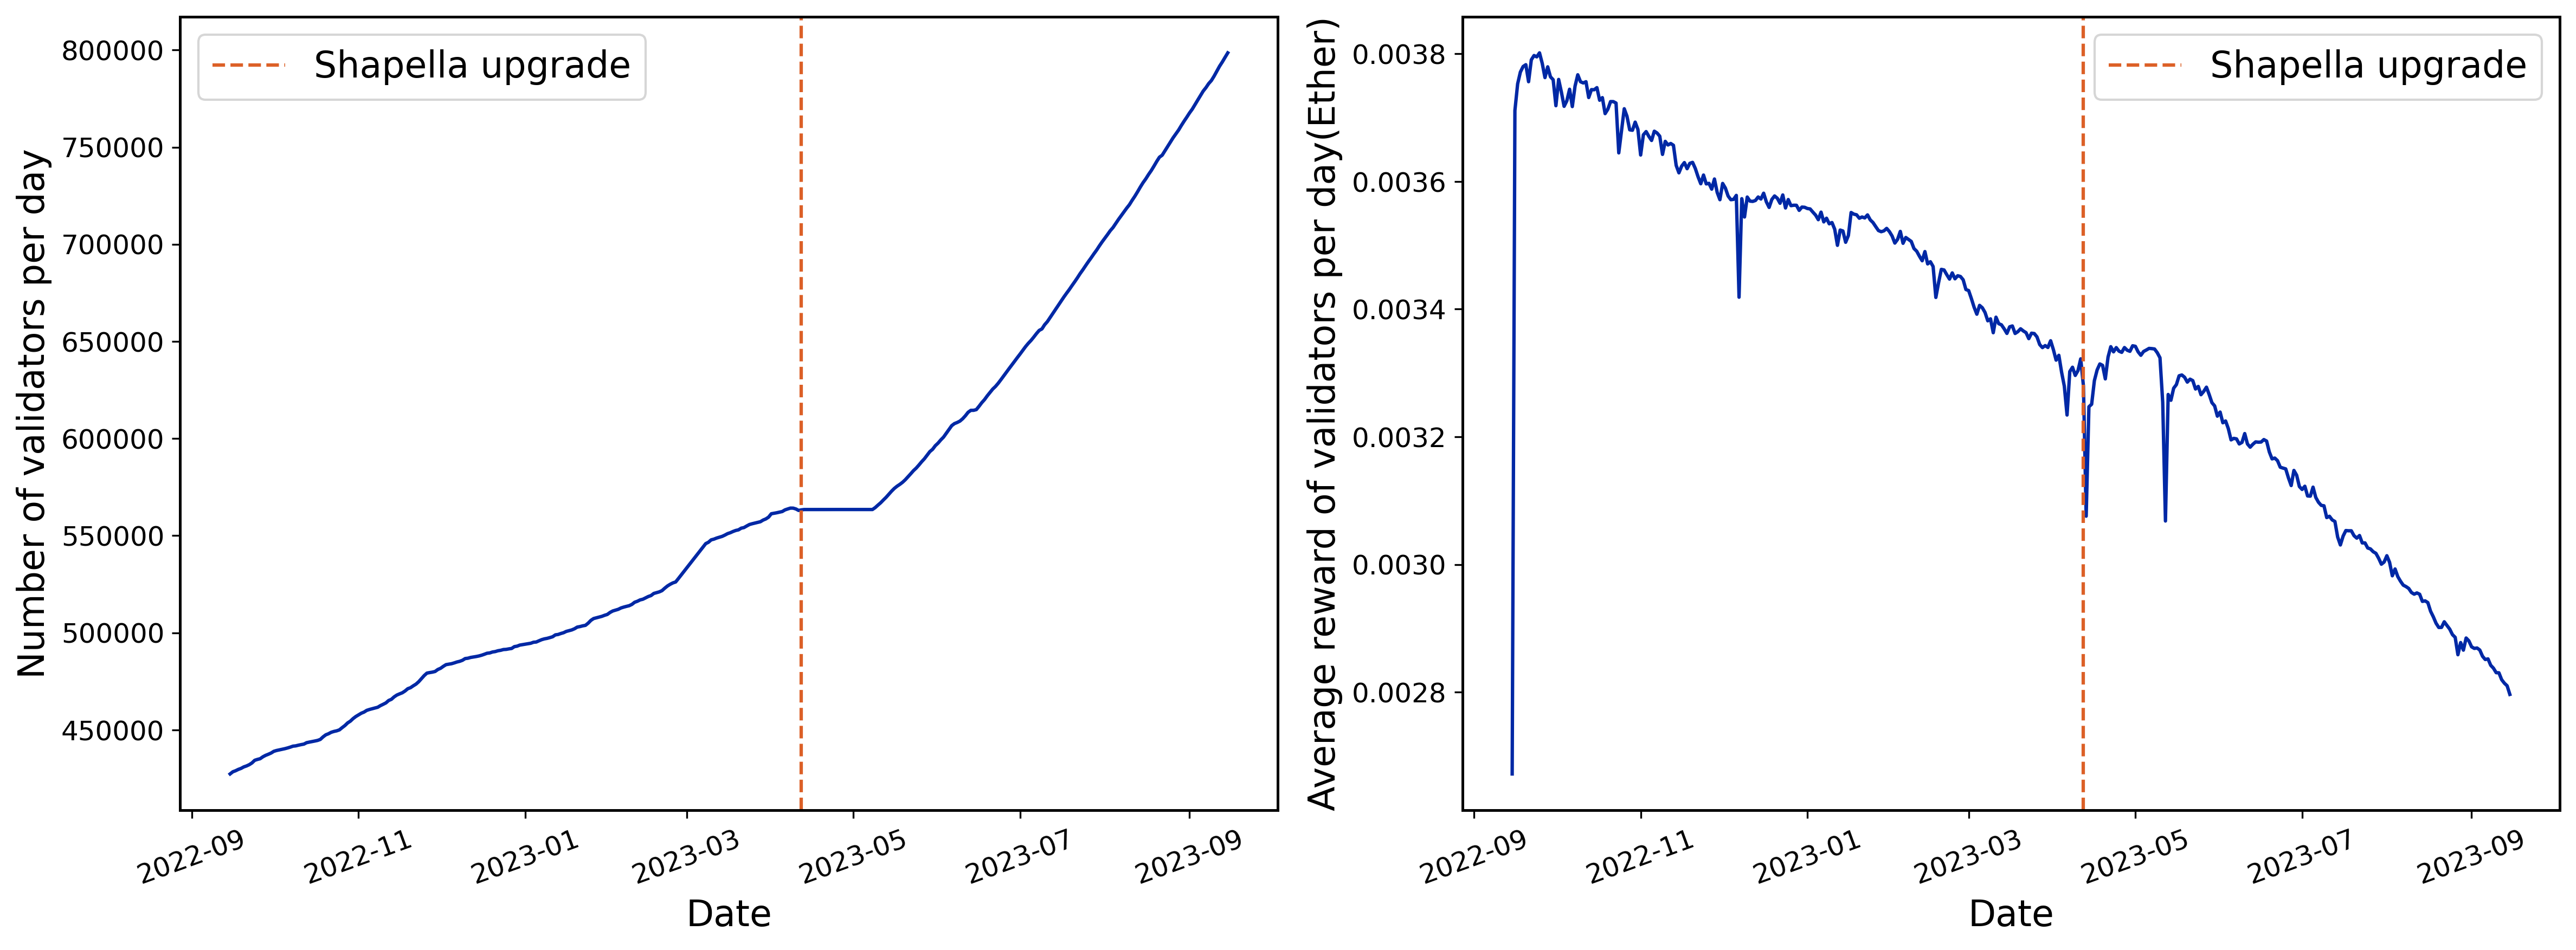

In [6]:
import matplotlib.pyplot as plt
df.rename(columns={'final_total_reward':'Total reward','proposer_total_reward':'Proposer reward','attestation_total_reward':'Attestation reward','sync_total_reward':'Sync committee reward'
                   },inplace=True)
df['date']=pd.to_datetime(df['date'])
# df=df[(df['date']>=pd.to_datetime('2022-09-16'))&(df['date']<=pd.to_datetime('2023-09-15'))]
# Calculate the mean of Validator_index by Date
# validator_counts = df.groupby('date')['validator_index'].nunique().reset_index()
# validator_means = df.groupby('date')['Total reward'].mean().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Add line plot to the first subplot
axs[0].plot(validator_counts['date'], validator_counts['validator_index'],lw=1.5)
# axs[0].set_title('Validator Counts over time')
#将上海升级用虚线画在图上
axs[0].axvline(pd.to_datetime('2023-04-12'), linestyle='--', lw=1.5,color='#dc6027',label='Shapella upgrade')
axs[0].legend(fontsize=16)
axs[0].set_ylabel('Number of validators per day',fontsize=16)
axs[0].set_xlabel('Date',fontsize=16)
axs[0].autoscale(enable=True, axis='x', tight=True)

axs[0].tick_params(axis='x', rotation=20)

# Add line plot to the second subplot
axs[1].plot(validator_means['date'], validator_means['Total reward']/10**9,lw=1.5)
# axs[1].set_title("Average Validator's Reward over Time")
axs[1].set_ylabel("Average reward of validators per day(Ether)",fontsize=16)
axs[1].set_xlabel('Date',fontsize=16)
axs[1].axvline(pd.to_datetime('2023-04-12'), linestyle='--', lw=1.5,color='#dc6027',label='Shapella upgrade')
axs[1].legend(fontsize=16)

axs[1].tick_params(axis='x', rotation=20)

plt.tight_layout()

plt.savefig('../figure/validator_count_reward_daily.pdf',bbox_inches='tight',dpi=300,facecolor='white')


## index plot

In [4]:
def sort_key(filename):
    order = {
        'total': 0,
        'proposer': 1, 
        'attestation': 2,
        'sync': 3
    }
    
    for key, value in order.items():
        if key in filename.lower():
            return value
    return 999  # 其他文件排在最后

In [5]:
import pandas as pd
from glob import glob
import os

files=glob('/local/scratch/exported/Ethereum_token_txs_data_TY_23/rewards/eth2_reward_ether/daily_validator_index_reward/*.parquet')
files.sort()
df_total=pd.DataFrame()
for file in files:
    file_name=file.split('/')[-1]
    if '3' in file_name:
        continue
    df=pd.read_parquet(file)
    df_total=pd.concat([df_total,df])

In [6]:
df_total.head(2)

,date,validator_index,Total reward,Attestation reward,Proposer reward,Sync committee reward
0,2022-09-15,0.0,2332229.0,2332229.0,0.0,0.0
1,2022-09-15,285743.0,2315295.0,2315295.0,0.0,0.0


In [23]:
res=pd.read_csv('../data/decentralization_metrics_data/gini_proposer_reward.csv')
res['date']=pd.to_datetime(res['date'])
res.to_csv('../data/decentralization_metrics_data/gini_proposer_reward.csv',index=False)

['../data/decentralization_metrics_data/gini_total_reward.csv', '../data/decentralization_metrics_data/HHI_total_reward.csv', '../data/decentralization_metrics_data/nakamoto_total_reward.csv', '../data/decentralization_metrics_data/Shannon_total_reward.csv', '../data/decentralization_metrics_data/HHI_proposer_reward.csv', '../data/decentralization_metrics_data/nakamoto_proposer_reward.csv', '../data/decentralization_metrics_data/gini_proposer_reward.csv', '../data/decentralization_metrics_data/Shannon_proposer_reward.csv', '../data/decentralization_metrics_data/gini_attestation_reward.csv', '../data/decentralization_metrics_data/HHI_attestation_reward.csv', '../data/decentralization_metrics_data/nakamoto_attestation_reward.csv', '../data/decentralization_metrics_data/Shannon_attestation_reward.csv', '../data/decentralization_metrics_data/HHI_sync_reward.csv', '../data/decentralization_metrics_data/nakamoto_sync_reward.csv', '../data/decentralization_metrics_data/gini_sync_reward.csv', 

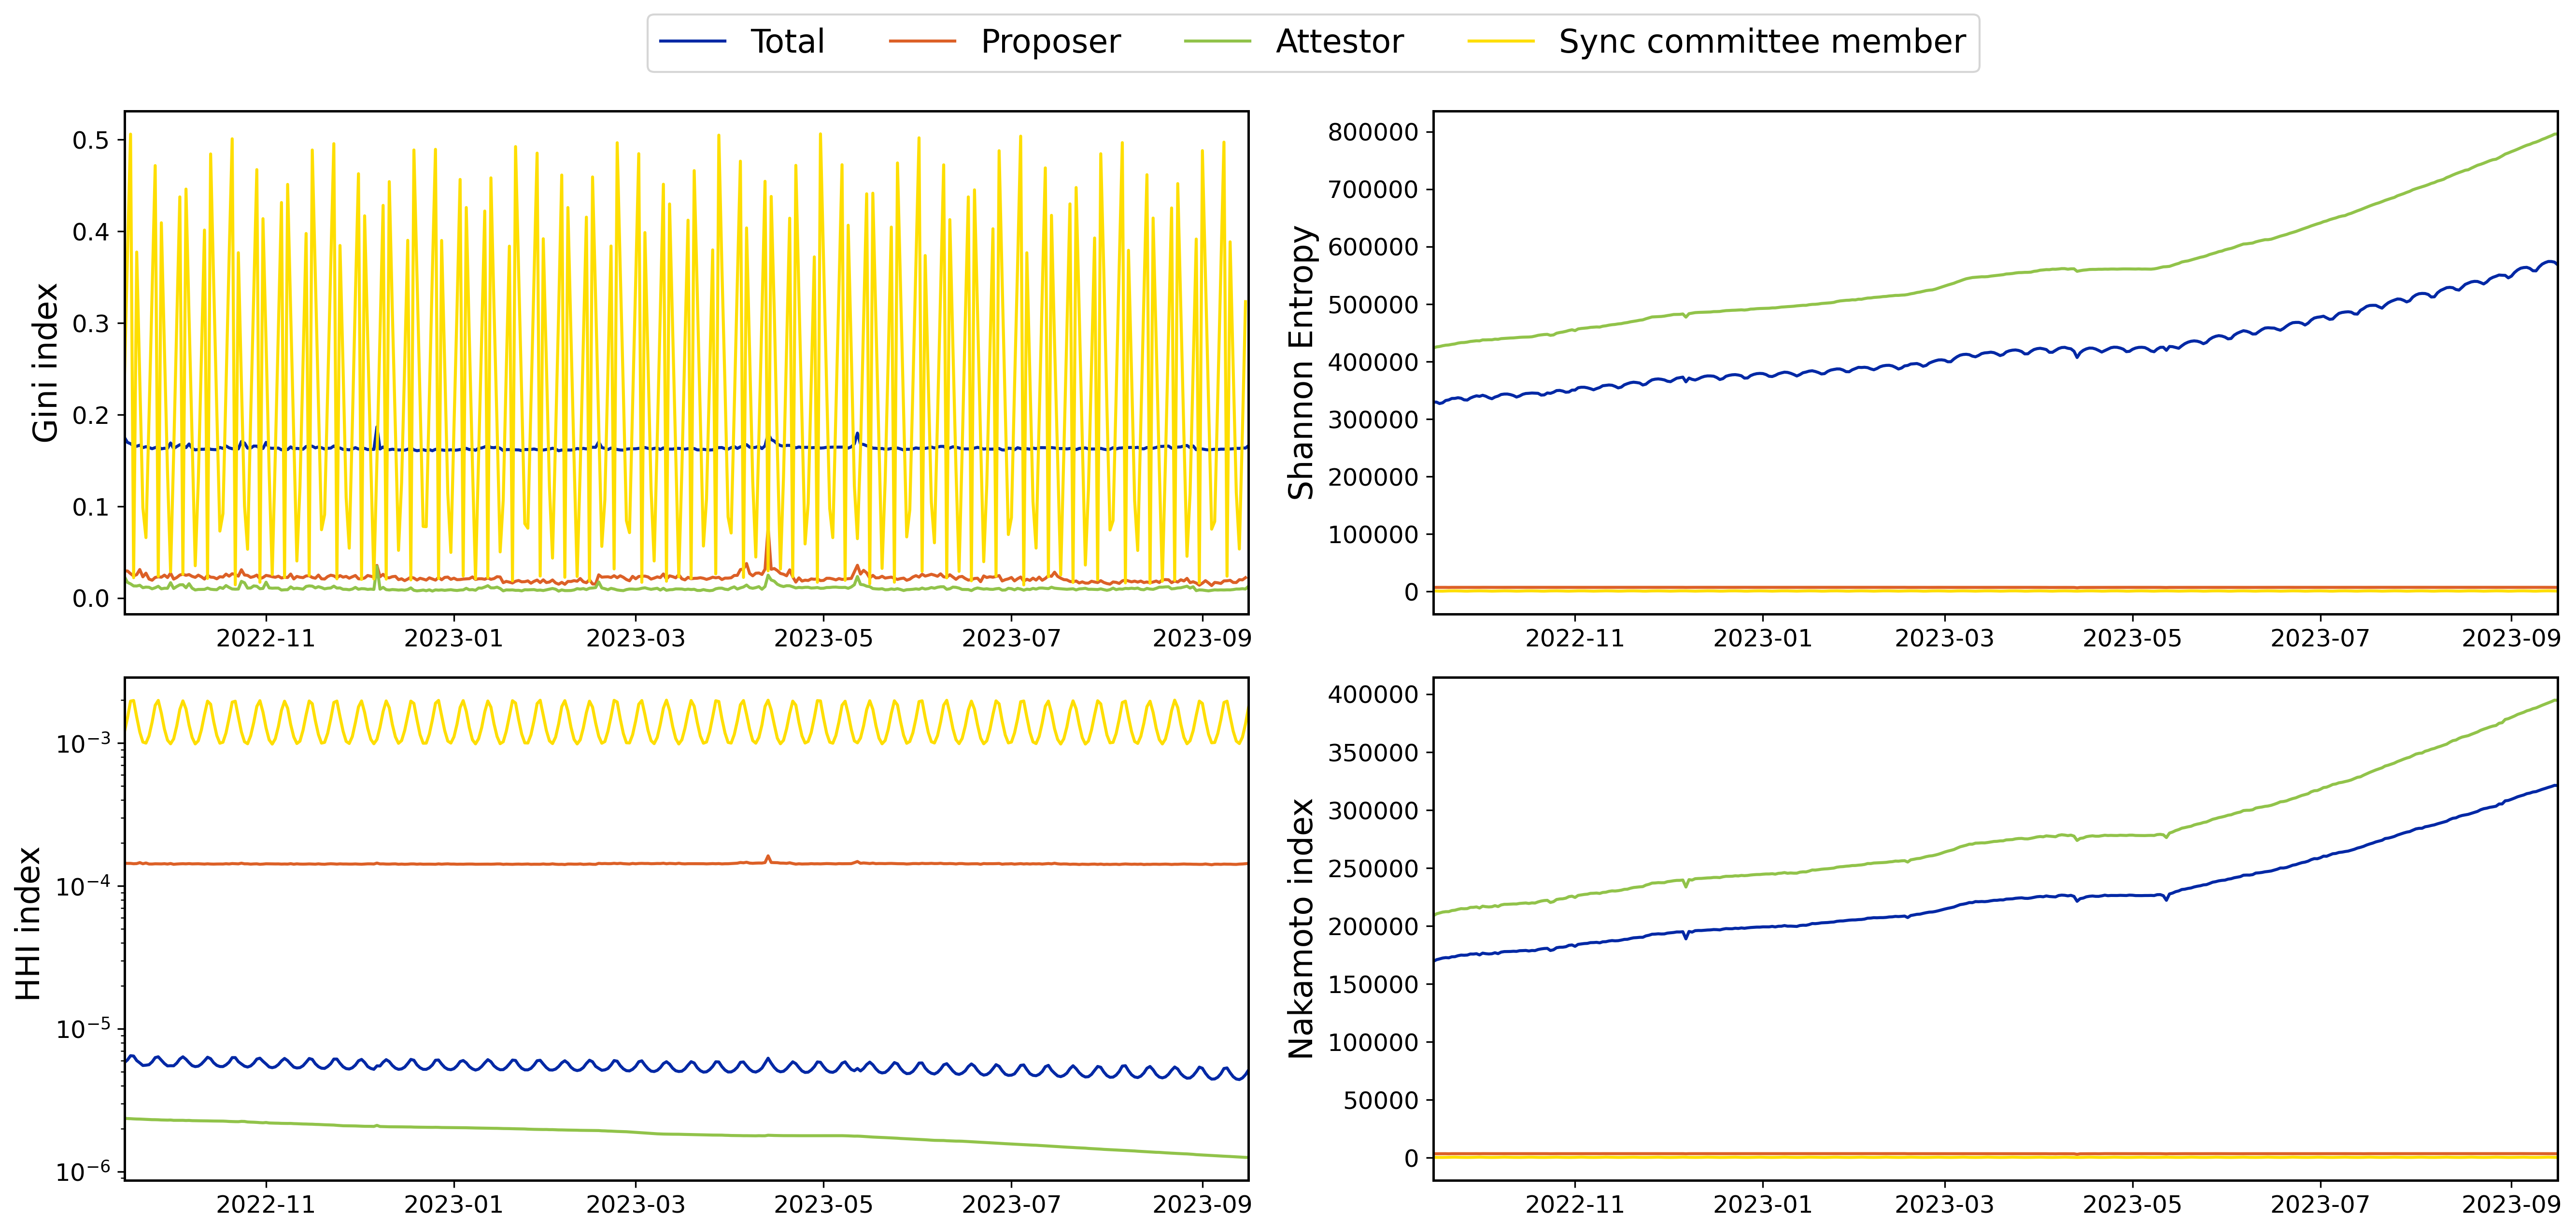

In [35]:
from glob import glob
files=glob('../data/decentralization_metrics_data/*.csv')
#将 file 排序，按照包含 total_reward 的文件排在最前面，然后是 proposer_reward，然后是 attestation_reward，最后是 sync_reward
files.sort(key=sort_key)
print(files)  
validator_counts =pd.read_csv('/home/user/yan/github/ETH2.0-reward/data/daily_validator_number_new.csv')
# 2*2 subplots
fig,axes=plt.subplots(2,2,figsize=(18,8),dpi=300)
for file in files:
    index=pd.read_csv(file)
    index['date']=pd.to_datetime(index['date'])
    index_name=file.split('/')[-1].split('.')[0].split('_')[0]
    index_name=index_name[0].upper()+index_name[1:]
    reward_type=file.split('/')[-1].split('.')[0].split('_')[1]
    # reward_type=['Total','Proposer','Attestor','Sync committee member']
    if index_name=='Gini':
        axes[0,0].plot(index['date'],index[reward_type],label=reward_type)
        #set the y-axis label
        axes[0,0].set_ylabel(f'{index_name} index',fontsize=16)
        #use percentage for y-axis
        # axes[0,0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
        # axes[0,0].legend(fontsize=16,ncol=2)
        axes[0,0].autoscale(enable=True, axis='x', tight=True)
        axes[0,0].set_xlim(left=pd.to_datetime('2022-09-16'))
        # axes[0,0].set_yscale('log') 
    if index_name=='Shannon':
        axes[0,1].plot(index['date'],index[reward_type],label=reward_type)
        axes[0,1].set_ylabel(f'Shannon Entropy',fontsize=16)
        #use percentage for y-axis
        # axes[0,1].legend(fontsize=16,ncol=2)
        axes[0,1].autoscale(enable=True, axis='x', tight=True)
        axes[0,1].set_xlim(left=pd.to_datetime('2022-09-16'))
    
    if index_name=='HHI':
        # reviese_HHI=index[reward_type]* validator_counts['validator_index'][1:].values
        axes[1,0].plot(index['date'],index[reward_type],label=reward_type)
        # axes[1,0].plot(index['date'],reviese_HHI,label=reward_type)
        axes[1,0].set_ylabel(f' HHI index',fontsize=16)
        #use percentage for y-axis
        axes[1,0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
        # axes[1,0].legend(fontsize=16,ncol=2)
        axes[1,0].autoscale(enable=True, axis='x', tight=True)
        axes[1,0].set_xlim(left=pd.to_datetime('2022-09-16'))
        axes[1,0].set_yscale('log')
        
    if index_name=='Nakamoto':
        axes[1,1].plot(index['date'],index[reward_type],label=reward_type)
        axes[1,1].set_ylabel(f'{index_name} index',fontsize=16)
        #use percentage for y-axis
        # axes[1,1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
        # axes[1,1].legend(fontsize=16,ncol=2)
        axes[1,1].autoscale(enable=True, axis='x', tight=True)
        axes[1,1].set_xlim(left=pd.to_datetime('2022-09-16'))
plt.tight_layout()
#rename the legend
handles, labels = axes[0,0].get_legend_handles_labels()
labels[0]='Total'
labels[1]='Proposer'
labels[2]='Attestor'
labels[3]='Sync committee member'
# labels[0]='Attestor'
# labels[1]='Proposer'
# labels[2]='Sync committee member'
# labels[3]='Total'
#set the legend location
plt.legend(handles,labels,fontsize=16,ncol=4,bbox_to_anchor=(0.5,2.35),frameon=True)
plt.savefig('../figure/4_index_timeseries.pdf',bbox_inches='tight',dpi=300,facecolor='white')



# References:
Code adapted from SoK: Blockchain Decentralization: https://arxiv.org/abs/2205.04256